In [45]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits.mplot3d import Axes3D

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Import Data

In [46]:
# Membaca file CSV
df = pd.read_csv('assets/file/vehicle_counts.csv')

# Menampilkan informasi awal
print(f"Jumlah baris awal: {len(df)}")
print(f"\nKolom yang ada: {df.columns.tolist()}")
print(f"\nData awal (10 baris pertama):")
df.head(10)

Jumlah baris awal: 1703

Kolom yang ada: ["'datetime'", " 'ocr_raw'", " 'count_of_car'", " 'count_of_motorcycle'", " 'count_of_heavy'", 'Unnamed: 5']

Data awal (10 baris pertama):


,'datetime','ocr_raw','count_of_car','count_of_motorcycle','count_of_heavy',Unnamed: 5
0,2025/11/04 12:00,12:01,14,15,0,NaN
1,2025/11/04 12:01,12:02,33,86,0,NaN
2,2025/11/04 12:02,12:03,66,130,0,NaN
3,2025/11/04 12:03,12:04,97,160,0,NaN
4,2025/11/04 12:04,12:05,111,254,0,NaN
5,2025/11/04 12:05,12:06,137,294,0,NaN
6,2025/11/04 12:06,12:07,167,326,1,NaN
7,2025/11/04 12:07,12:08,196,434,2,NaN
8,2025/11/04 12:08,12:09,237,484,4,NaN
9,2025/11/04 12:09,12:10,263,538,6,NaN


## 2. Hapus Kolom yang Tidak Diperlukan

In [47]:
# Hapus kolom Unnamed jika ada
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Kolom setelah dibersihkan: {df.columns.tolist()}")
df.head()

Kolom setelah dibersihkan: ["'datetime'", " 'ocr_raw'", " 'count_of_car'", " 'count_of_motorcycle'", " 'count_of_heavy'"]


,'datetime','ocr_raw','count_of_car','count_of_motorcycle','count_of_heavy'
0,2025/11/04 12:00,12:01,14,15,0
1,2025/11/04 12:01,12:02,33,86,0
2,2025/11/04 12:02,12:03,66,130,0
3,2025/11/04 12:03,12:04,97,160,0
4,2025/11/04 12:04,12:05,111,254,0


## 3. Bersihkan Nama Kolom

Menghapus tanda petik dari nama kolom

In [48]:
# Bersihkan nama kolom dari tanda petik
df.columns = df.columns.str.replace("'", "").str.strip()

print(f"Nama kolom yang sudah dibersihkan: {df.columns.tolist()}")
df.head()

Nama kolom yang sudah dibersihkan: ['datetime', 'ocr_raw', 'count_of_car', 'count_of_motorcycle', 'count_of_heavy']


,datetime,ocr_raw,count_of_car,count_of_motorcycle,count_of_heavy
0,2025/11/04 12:00,12:01,14,15,0
1,2025/11/04 12:01,12:02,33,86,0
2,2025/11/04 12:02,12:03,66,130,0
3,2025/11/04 12:03,12:04,97,160,0
4,2025/11/04 12:04,12:05,111,254,0


## 4. Deteksi Periode dan Reset

Mendeteksi ketika counting direset (nilai menurun = periode baru dimulai)

In [49]:
# Konversi kolom datetime ke format datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %H:%M')

# Deteksi reset: ketika nilai count menurun dari baris sebelumnya
df['is_reset'] = False
df.loc[1:, 'is_reset'] = (
    (df['count_of_car'].diff() < 0) | 
    (df['count_of_motorcycle'].diff() < 0)
)

# Baris pertama selalu awal periode
df.loc[0, 'is_reset'] = True

# Buat ID periode
df['period_id'] = df['is_reset'].cumsum()

print(f"Jumlah periode yang terdeteksi: {df['period_id'].max()}")
print(f"\nContoh deteksi reset:")
print(df[df['is_reset'] == True][['datetime', 'count_of_car', 'count_of_motorcycle', 'count_of_heavy', 'period_id']].head(10))

Jumlah periode yang terdeteksi: 152

Contoh deteksi reset:
              datetime  count_of_car  count_of_motorcycle  count_of_heavy  \
0  2025-11-04 12:00:00            14                   15               0   
14 2025-11-04 14:00:00            34                   45               0   
25 2025-11-04 15:00:00            39                   53               1   
36 2025-11-04 16:00:00            25                   83               0   
47 2025-11-04 17:00:00            27                  143               0   
56 2025-11-04 18:00:00             9                   17               0   
67 2025-11-04 19:00:00            13                   25               0   
78 2025-11-04 20:00:00            11                   39               0   
86 2025-11-04 21:00:00             7                   48               0   
98 2025-11-04 22:00:00            12                   86               0   

    period_id  
0           1  
14          2  
25          3  
36          4  
47          5

## 5. Hitung Data Incremental

Mengubah data kumulatif menjadi data incremental (selisih antar baris)

In [50]:
# Buat dataframe hasil
df_result = df.copy()

# Inisialisasi kolom incremental
df_result['datetime_start'] = df_result['datetime']
df_result['datetime_end'] = df_result['datetime'].shift(-1)
df_result['car_increment'] = 0
df_result['motorcycle_increment'] = 0
df_result['heavy_increment'] = 0

# Untuk baris pertama setiap periode, gunakan nilai asli
df_result.loc[df_result['is_reset'], 'car_increment'] = df_result.loc[df_result['is_reset'], 'count_of_car']
df_result.loc[df_result['is_reset'], 'motorcycle_increment'] = df_result.loc[df_result['is_reset'], 'count_of_motorcycle']
df_result.loc[df_result['is_reset'], 'heavy_increment'] = df_result.loc[df_result['is_reset'], 'count_of_heavy']

# Untuk baris lainnya, hitung selisih dengan baris sebelumnya dalam periode yang sama
for i in range(1, len(df_result)):
    if not df_result.loc[i, 'is_reset']:
        # Dalam periode yang sama, hitung selisih
        df_result.loc[i, 'car_increment'] = df_result.loc[i, 'count_of_car'] - df_result.loc[i-1, 'count_of_car']
        df_result.loc[i, 'motorcycle_increment'] = df_result.loc[i, 'count_of_motorcycle'] - df_result.loc[i-1, 'count_of_motorcycle']
        df_result.loc[i, 'heavy_increment'] = df_result.loc[i, 'count_of_heavy'] - df_result.loc[i-1, 'count_of_heavy']

# Hapus baris terakhir setiap periode (karena tidak ada datetime_end)
last_rows_per_period = df_result.groupby('period_id').tail(1).index
df_result = df_result.drop(last_rows_per_period)

print(f"Jumlah baris setelah konversi: {len(df_result)}")
df_result[['datetime_start', 'datetime_end', 'ocr_raw', 'car_increment', 'motorcycle_increment', 'heavy_increment']].head(15)

Jumlah baris setelah konversi: 1551


,datetime_start,datetime_end,ocr_raw,car_increment,motorcycle_increment,heavy_increment
0,2025-11-04 12:00:00,2025-11-04 12:01:00,12:01,14,15,0
1,2025-11-04 12:01:00,2025-11-04 12:02:00,12:02,19,71,0
2,2025-11-04 12:02:00,2025-11-04 12:03:00,12:03,33,44,0
3,2025-11-04 12:03:00,2025-11-04 12:04:00,12:04,31,30,0
4,2025-11-04 12:04:00,2025-11-04 12:05:00,12:05,14,94,0
5,2025-11-04 12:05:00,2025-11-04 12:06:00,12:06,26,40,0
6,2025-11-04 12:06:00,2025-11-04 12:07:00,12:07,30,32,1
7,2025-11-04 12:07:00,2025-11-04 12:08:00,12:08,29,108,1
8,2025-11-04 12:08:00,2025-11-04 12:09:00,12:09,41,50,2
9,2025-11-04 12:09:00,2025-11-04 12:10:00,12:10,26,54,2


## 6. Buat Dataset Final

Menyusun ulang kolom sesuai format yang diinginkan

In [51]:
# Pilih dan rename kolom sesuai format yang diinginkan
df_final = df_result[[
    'datetime_start', 
    'datetime_end', 
    'ocr_raw', 
    'car_increment', 
    'motorcycle_increment', 
    'heavy_increment'
]].copy()

# Rename kolom
df_final.columns = [
    'datetime_start', 
    'datetime_end', 
    'ocr_raw', 
    'count_of_car', 
    'count_of_motorcycle', 
    'count_of_heavy'
]

# Urutkan berdasarkan datetime_start secara ascending (dari tanggal terlama ke terbaru)
df_final = df_final.sort_values('datetime_start', ascending=True)

# Reset index
df_final = df_final.reset_index(drop=True)

print(f"Dataset final:")
print(f"Total baris: {len(df_final)}")
print(f"\nContoh data (15 baris pertama):")
df_final.head(15)

Dataset final:
Total baris: 1551

Contoh data (15 baris pertama):


,datetime_start,datetime_end,ocr_raw,count_of_car,count_of_motorcycle,count_of_heavy
0,2025-11-02 22:00:00,2025-11-02 22:01:00,10:01,16,42,0
1,2025-11-02 22:01:00,2025-11-02 22:00:00,10:00,0,1,0
2,2025-11-02 22:01:00,2025-11-02 22:02:00,10:02,11,43,0
3,2025-11-02 22:02:00,2025-11-02 22:03:00,10:03,16,100,0
4,2025-11-02 22:03:00,2025-11-02 22:04:00,10:04,16,34,0
5,2025-11-02 22:04:00,2025-11-02 22:05:00,10:05,16,43,0
6,2025-11-02 22:05:00,2025-11-02 22:06:00,10:06,16,69,0
7,2025-11-02 22:06:00,2025-11-02 22:09:00,10:09,9,35,0
8,2025-11-02 22:09:00,2025-11-02 22:10:00,10:10,9,46,0
9,2025-11-02 23:00:00,2025-11-02 23:01:00,11:01,6,48,0


## 7. Verifikasi Data

In [52]:
# Cek apakah ada nilai negatif (indikasi error)
negative_car = (df_final['count_of_car'] < 0).sum()
negative_motorcycle = (df_final['count_of_motorcycle'] < 0).sum()
negative_heavy = (df_final['count_of_heavy'] < 0).sum()

print("Verifikasi nilai negatif:")
print(f"Baris dengan count_of_car negatif: {negative_car}")
print(f"Baris dengan count_of_motorcycle negatif: {negative_motorcycle}")
print(f"Baris dengan count_of_heavy negatif: {negative_heavy}")

if negative_car + negative_motorcycle + negative_heavy > 0:
    print("\nPeringatan: Ada nilai negatif yang terdeteksi!")
    print(df_final[(df_final['count_of_car'] < 0) | 
                   (df_final['count_of_motorcycle'] < 0) | 
                   (df_final['count_of_heavy'] < 0)])
else:
    print("\n✓ Tidak ada nilai negatif. Data valid!")

Verifikasi nilai negatif:
Baris dengan count_of_car negatif: 0
Baris dengan count_of_motorcycle negatif: 0
Baris dengan count_of_heavy negatif: 0

✓ Tidak ada nilai negatif. Data valid!


## 8. Statistik Data

In [53]:
print("Ringkasan Statistik Data Incremental:")
print(df_final[['count_of_car', 'count_of_motorcycle', 'count_of_heavy']].describe())

print(f"\nRentang waktu data:")
print(f"Dari: {df_final['datetime_start'].min()}")
print(f"Sampai: {df_final['datetime_end'].max()}")

print(f"\nTotal kendaraan per tipe:")
print(f"Total mobil: {df_final['count_of_car'].sum()}")
print(f"Total motor: {df_final['count_of_motorcycle'].sum()}")
print(f"Total kendaraan berat: {df_final['count_of_heavy'].sum()}")

Ringkasan Statistik Data Incremental:
       count_of_car  count_of_motorcycle  count_of_heavy
count   1551.000000          1551.000000     1551.000000
mean      15.965184            50.039974        0.360413
std       12.634722            36.746661        1.005639
min        0.000000             0.000000        0.000000
25%        4.000000            21.000000        0.000000
50%       15.000000            45.000000        0.000000
75%       25.000000            72.000000        0.000000
max      143.000000           360.000000       11.000000

Rentang waktu data:
Dari: 2025-11-02 22:00:00
Sampai: 2025-11-09 19:09:00

Total kendaraan per tipe:
Total mobil: 24762
Total motor: 77612
Total kendaraan berat: 559


## 9. Simpan Data yang Sudah Diproses

In [54]:
# Simpan ke file CSV baru
df_final.to_csv('assets/file/vehicle_counts_processed.csv', index=False)
print("Data yang sudah diproses telah disimpan ke: assets/file/vehicle_counts_processed.csv")

Data yang sudah diproses telah disimpan ke: assets/file/vehicle_counts_processed.csv


## 10. Perbandingan Data Original vs Processed

In [55]:
print("Perbandingan data original (kumulatif) vs processed (incremental):")
print("\n=== DATA ORIGINAL (10 baris pertama) ===")
print(df[['datetime', 'ocr_raw', 'count_of_car', 'count_of_motorcycle', 'count_of_heavy']].head(10))

print("\n=== DATA PROCESSED (10 baris pertama) ===")
print(df_final.head(10))

Perbandingan data original (kumulatif) vs processed (incremental):

=== DATA ORIGINAL (10 baris pertama) ===
             datetime ocr_raw  count_of_car  count_of_motorcycle  \
0 2025-11-04 12:00:00   12:01            14                   15   
1 2025-11-04 12:01:00   12:02            33                   86   
2 2025-11-04 12:02:00   12:03            66                  130   
3 2025-11-04 12:03:00   12:04            97                  160   
4 2025-11-04 12:04:00   12:05           111                  254   
5 2025-11-04 12:05:00   12:06           137                  294   
6 2025-11-04 12:06:00   12:07           167                  326   
7 2025-11-04 12:07:00   12:08           196                  434   
8 2025-11-04 12:08:00   12:09           237                  484   
9 2025-11-04 12:09:00   12:10           263                  538   

   count_of_heavy  
0               0  
1               0  
2               0  
3               0  
4               0  
5               0  
6 

# CLUSTERING K-MEANS

---

## 11. Distribusi Data untuk Clustering

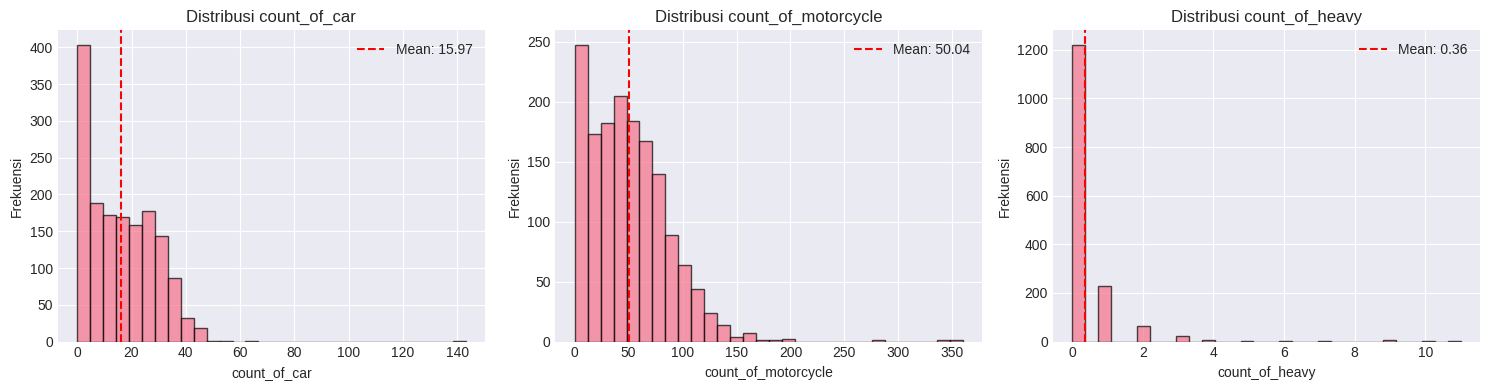


Rasio skala antar variabel:
Mean car: 15.97
Mean motorcycle: 50.04
Mean heavy: 0.36

Rasio motorcycle/car: 3.13
Rasio car/heavy: 44.17


In [56]:
# Visualisasi distribusi data
features = ['count_of_car', 'count_of_motorcycle', 'count_of_heavy']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, feature in enumerate(features):
    axes[idx].hist(df_final[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribusi {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frekuensi')
    axes[idx].axvline(df_final[feature].mean(), color='red', linestyle='--', label=f'Mean: {df_final[feature].mean():.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

print("\nRasio skala antar variabel:")
print(f"Mean car: {df_final['count_of_car'].mean():.2f}")
print(f"Mean motorcycle: {df_final['count_of_motorcycle'].mean():.2f}")
print(f"Mean heavy: {df_final['count_of_heavy'].mean():.2f}")
print(f"\nRasio motorcycle/car: {df_final['count_of_motorcycle'].mean() / df_final['count_of_car'].mean():.2f}")
print(f"Rasio car/heavy: {df_final['count_of_car'].mean() / (df_final['count_of_heavy'].mean() + 0.001):.2f}")

## 12. Pemberian Weight dan Scaling

Karena skala count_of_heavy jauh lebih kecil dari car dan motorcycle, kita akan memberikan weight:
- Heavy vehicle: weight = 3.0 (dampak paling signifikan)
- Car: weight = 1.0 (baseline)
- Motorcycle: weight = 0.5 (lebih ringan dampaknya)

In [57]:
# Definisikan weights berdasarkan kepentingan dan dampak kendaraan
weights = {
    'count_of_car': 1.0,
    'count_of_motorcycle': 0.5,  # Motorcycle lebih ringan dampaknya
    'count_of_heavy': 2.0        # Heavy vehicle dampak paling besar
}

print("Weights yang digunakan:")
for feature, weight in weights.items():
    print(f"  {feature}: {weight}")

# Buat dataframe dengan weighted features
df_weighted = df_final[features].copy()
for feature, weight in weights.items():
    df_weighted[feature] = df_weighted[feature] * weight

print("\nStatistik setelah weighting:")
print(df_weighted.describe())

# Standardisasi data (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_weighted)

# Simpan sebagai DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=features)

print("\nStatistik setelah standardisasi:")
print(df_scaled.describe())
print(f"\nShape data untuk clustering: {X_scaled.shape}")

Weights yang digunakan:
  count_of_car: 1.0
  count_of_motorcycle: 0.5
  count_of_heavy: 2.0

Statistik setelah weighting:
       count_of_car  count_of_motorcycle  count_of_heavy
count   1551.000000          1551.000000     1551.000000
mean      15.965184            25.019987        0.720825
std       12.634722            18.373331        2.011277
min        0.000000             0.000000        0.000000
25%        4.000000            10.500000        0.000000
50%       15.000000            22.500000        0.000000
75%       25.000000            36.000000        0.000000
max      143.000000           180.000000       22.000000

Statistik setelah standardisasi:
       count_of_car  count_of_motorcycle  count_of_heavy
count  1.551000e+03         1.551000e+03    1.551000e+03
mean   1.832476e-17         9.162382e-18   -4.581191e-18
std    1.000323e+00         1.000323e+00    1.000323e+00
min   -1.264003e+00        -1.362195e+00   -3.585074e-01
25%   -9.473135e-01        -7.905301e-01   -3

## 13. K-Means Clustering dengan K=3

In [58]:
# Set random state untuk reproducibility
random_state = 42

# Membuat model K-Means dengan k=3
kmeans = KMeans(n_clusters=3, random_state=random_state, n_init=10, max_iter=300)

# Fitting model
cluster_labels = kmeans.fit_predict(X_scaled)

# Menambahkan hasil clustering ke dataframe
df_final['cluster'] = cluster_labels

print(f"Jumlah cluster: {kmeans.n_clusters}")
print(f"\nJumlah data per cluster:")
print(df_final['cluster'].value_counts().sort_index())

# Centroid clusters (dalam skala asli weighted)
centroids_scaled = kmeans.cluster_centers_
centroids_weighted = scaler.inverse_transform(centroids_scaled)

print("\nCentroid clusters (weighted values):")
centroids_df = pd.DataFrame(centroids_weighted, columns=features)
print(centroids_df)

Jumlah cluster: 3

Jumlah data per cluster:
cluster
0    818
1    718
2     15
Name: count, dtype: int64

Centroid clusters (weighted values):
   count_of_car  count_of_motorcycle  count_of_heavy
0     25.178484            36.805012        0.963325
1      5.279944            11.314763        0.128134
2     25.000000            38.366667       15.866667


In [59]:
# Statistik per cluster (nilai original tanpa weight)
print("\n" + "="*60)
print("KARAKTERISTIK SETIAP CLUSTER (Original Values)")
print("="*60)

for cluster_id in sorted(df_final['cluster'].unique()):
    cluster_data = df_final[df_final['cluster'] == cluster_id][features]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Jumlah data: {len(cluster_data)}")
    print(f"\nMean:")
    print(cluster_data.mean())
    print(f"\nMedian:")
    print(cluster_data.median())
    print(f"\nStd Dev:")
    print(cluster_data.std())


KARAKTERISTIK SETIAP CLUSTER (Original Values)

--- CLUSTER 0 ---
Jumlah data: 818

Mean:
count_of_car           25.178484
count_of_motorcycle    73.610024
count_of_heavy          0.481663
dtype: float64

Median:
count_of_car           25.0
count_of_motorcycle    70.0
count_of_heavy          0.0
dtype: float64

Std Dev:
count_of_car            8.592213
count_of_motorcycle    31.094333
count_of_heavy          0.788709
dtype: float64

--- CLUSTER 1 ---
Jumlah data: 718

Mean:
count_of_car            5.279944
count_of_motorcycle    22.629526
count_of_heavy          0.064067
dtype: float64

Median:
count_of_car            4.0
count_of_motorcycle    20.0
count_of_heavy          0.0
dtype: float64

Std Dev:
count_of_car            5.093646
count_of_motorcycle    17.247701
count_of_heavy          0.296547
dtype: float64

--- CLUSTER 2 ---
Jumlah data: 15

Mean:
count_of_car           25.000000
count_of_motorcycle    76.733333
count_of_heavy          7.933333
dtype: float64

Median:
count_of_

## 14. Evaluasi: Silhouette Score

In [60]:
# Hitung Silhouette Score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print("="*60)
print("EVALUASI: SILHOUETTE SCORE")
print("="*60)
print(f"\nSilhouette Score: {silhouette_avg:.4f}")
print(f"\nInterpretasi:")
if silhouette_avg > 0.7:
    print("  > 0.7: Strong structure (Sangat baik)")
elif silhouette_avg > 0.5:
    print("  0.5-0.7: Reasonable structure (Baik)")
elif silhouette_avg > 0.25:
    print("  0.25-0.5: Weak structure (Cukup)")
else:
    print("  < 0.25: No substantial structure (Kurang baik)")

# Hitung silhouette score per cluster
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

print(f"\nSilhouette Score per Cluster:")
for cluster_id in sorted(df_final['cluster'].unique()):
    cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_id]
    print(f"  Cluster {cluster_id}: {cluster_silhouette_values.mean():.4f}")

EVALUASI: SILHOUETTE SCORE

Silhouette Score: 0.4539

Interpretasi:
  0.25-0.5: Weak structure (Cukup)

Silhouette Score per Cluster:
  Cluster 0: 0.2898
  Cluster 1: 0.6410
  Cluster 2: 0.4500


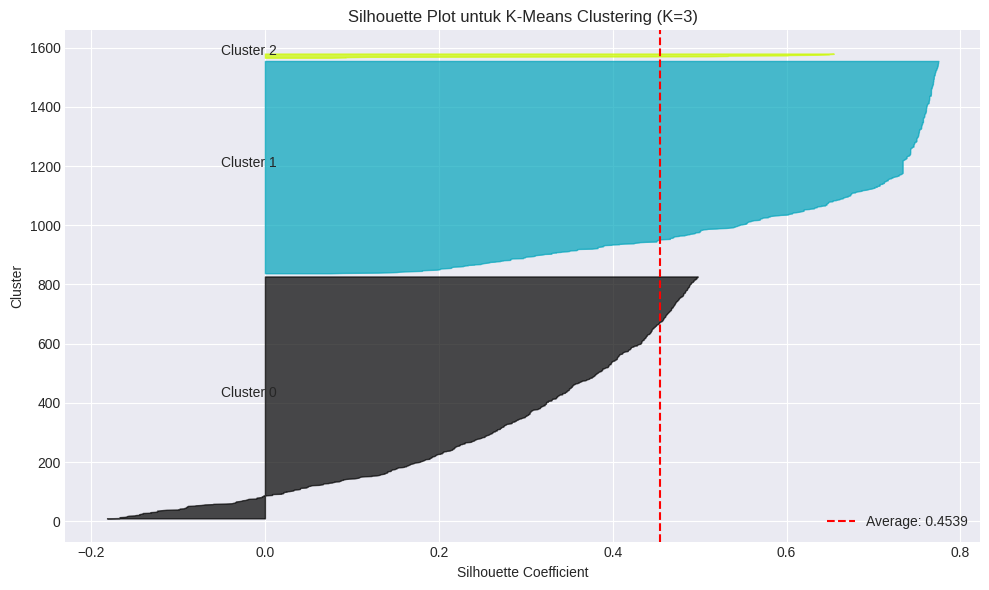

In [61]:
# Visualisasi Silhouette Plot
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(3):
    # Aggregate silhouette scores untuk cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / 3)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot untuk K-Means Clustering (K=3)')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')

# Garis vertikal untuk rata-rata silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Average: {silhouette_avg:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

## 15. Evaluasi: BSS/TSS Ratio

In [62]:
# Hitung Total Sum of Squares (TSS)
overall_mean = X_scaled.mean(axis=0)
tss = np.sum((X_scaled - overall_mean) ** 2)

# Hitung Between-cluster Sum of Squares (BSS)
bss = 0
for i in range(3):
    cluster_data = X_scaled[cluster_labels == i]
    cluster_size = len(cluster_data)
    cluster_center = centroids_scaled[i]
    bss += cluster_size * np.sum((cluster_center - overall_mean) ** 2)

# Hitung Within-cluster Sum of Squares (WSS)
wss = kmeans.inertia_

# Hitung BSS/TSS ratio
bss_tss_ratio = bss / tss

print("="*60)
print("EVALUASI: BSS/TSS RATIO")
print("="*60)
print(f"\nTotal Sum of Squares (TSS): {tss:.4f}")
print(f"Between-cluster Sum of Squares (BSS): {bss:.4f}")
print(f"Within-cluster Sum of Squares (WSS): {wss:.4f}")
print(f"\nVerifikasi: BSS + WSS = {bss + wss:.4f} (should equal TSS = {tss:.4f})")
print(f"\n" + "="*60)
print(f"BSS/TSS Ratio: {bss_tss_ratio:.4f} ({bss_tss_ratio*100:.2f}%)")
print("="*60)
print(f"\nInterpretasi:")
print(f"  BSS/TSS = {bss_tss_ratio:.4f} berarti {bss_tss_ratio*100:.2f}% variasi data")
print(f"  dijelaskan oleh pembagian cluster.")
print(f"\n  WSS/TSS = {(wss/tss):.4f} berarti {(wss/tss)*100:.2f}% variasi data")
print(f"  masih ada dalam cluster (tidak dijelaskan).")

if bss_tss_ratio > 0.7:
    print("\n  > 0.7: Clustering sangat baik")
elif bss_tss_ratio > 0.5:
    print("\n  0.5-0.7: Clustering baik")
elif bss_tss_ratio > 0.3:
    print("\n  0.3-0.5: Clustering cukup")
else:
    print("\n  < 0.3: Clustering kurang baik")

EVALUASI: BSS/TSS RATIO

Total Sum of Squares (TSS): 4653.0000
Between-cluster Sum of Squares (BSS): 2626.6707
Within-cluster Sum of Squares (WSS): 2026.3293

Verifikasi: BSS + WSS = 4653.0000 (should equal TSS = 4653.0000)

BSS/TSS Ratio: 0.5645 (56.45%)

Interpretasi:
  BSS/TSS = 0.5645 berarti 56.45% variasi data
  dijelaskan oleh pembagian cluster.

  WSS/TSS = 0.4355 berarti 43.55% variasi data
  masih ada dalam cluster (tidak dijelaskan).

  0.5-0.7: Clustering baik


## 16. Visualisasi Hasil Clustering

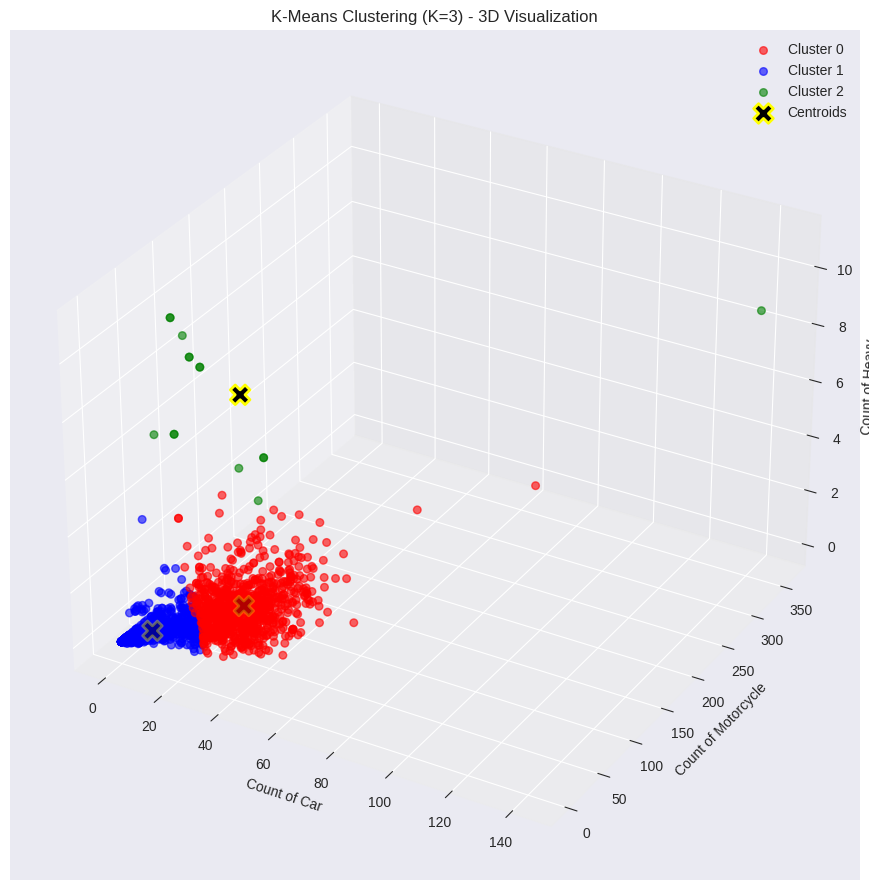

In [63]:
# Visualisasi 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_final[df_final['cluster'] == i]
    ax.scatter(cluster_data['count_of_car'], 
               cluster_data['count_of_motorcycle'], 
               cluster_data['count_of_heavy'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)

# Plot centroids (dalam skala original, harus di-unweight)
centroids_original = centroids_weighted.copy()
for idx, feature in enumerate(features):
    centroids_original[:, idx] = centroids_original[:, idx] / weights[feature]

ax.scatter(centroids_original[:, 0], 
           centroids_original[:, 1], 
           centroids_original[:, 2],
           c='black', marker='X', s=200, label='Centroids', edgecolor='yellow', linewidth=2)

ax.set_xlabel('Count of Car')
ax.set_ylabel('Count of Motorcycle')
ax.set_zlabel('Count of Heavy')
ax.set_title('K-Means Clustering (K=3) - 3D Visualization')
ax.legend()

plt.tight_layout()
plt.show()

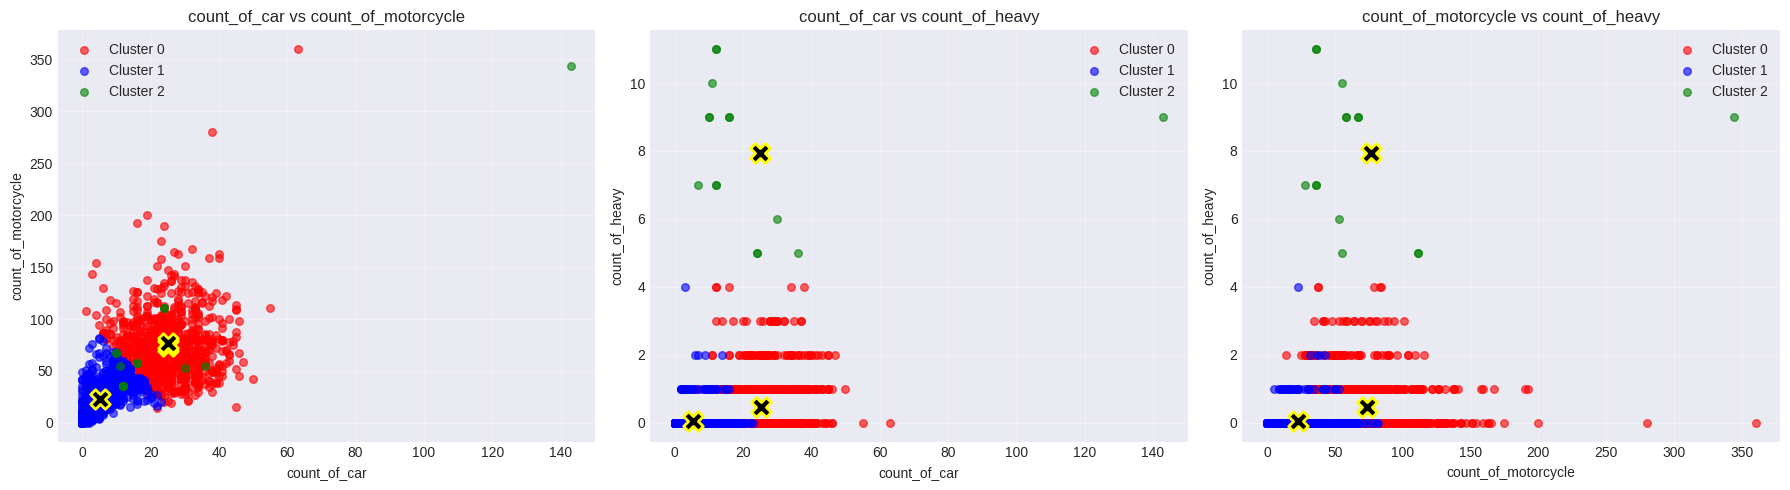

In [64]:
# Visualisasi 2D pairwise
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [
    ('count_of_car', 'count_of_motorcycle'),
    ('count_of_car', 'count_of_heavy'),
    ('count_of_motorcycle', 'count_of_heavy')
]

for idx, (x_feature, y_feature) in enumerate(pairs):
    for i in range(3):
        cluster_data = df_final[df_final['cluster'] == i]
        axes[idx].scatter(cluster_data[x_feature], 
                         cluster_data[y_feature],
                         c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
    
    # Plot centroids
    x_idx = features.index(x_feature)
    y_idx = features.index(y_feature)
    axes[idx].scatter(centroids_original[:, x_idx], 
                     centroids_original[:, y_idx],
                     c='black', marker='X', s=200, edgecolor='yellow', linewidth=2)
    
    axes[idx].set_xlabel(x_feature)
    axes[idx].set_ylabel(y_feature)
    axes[idx].set_title(f'{x_feature} vs {y_feature}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipykernel_211235/98344517.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'Cluster {i}' for i in range(3)])
/tmp/ipykernel_211235/98344517.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'Cluster {i}' for i in range(3)])
/tmp/ipykernel_211235/98344517.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[idx].boxplot(data_to_plot, labels=[f'Cluster {i}' for i in range(3)])


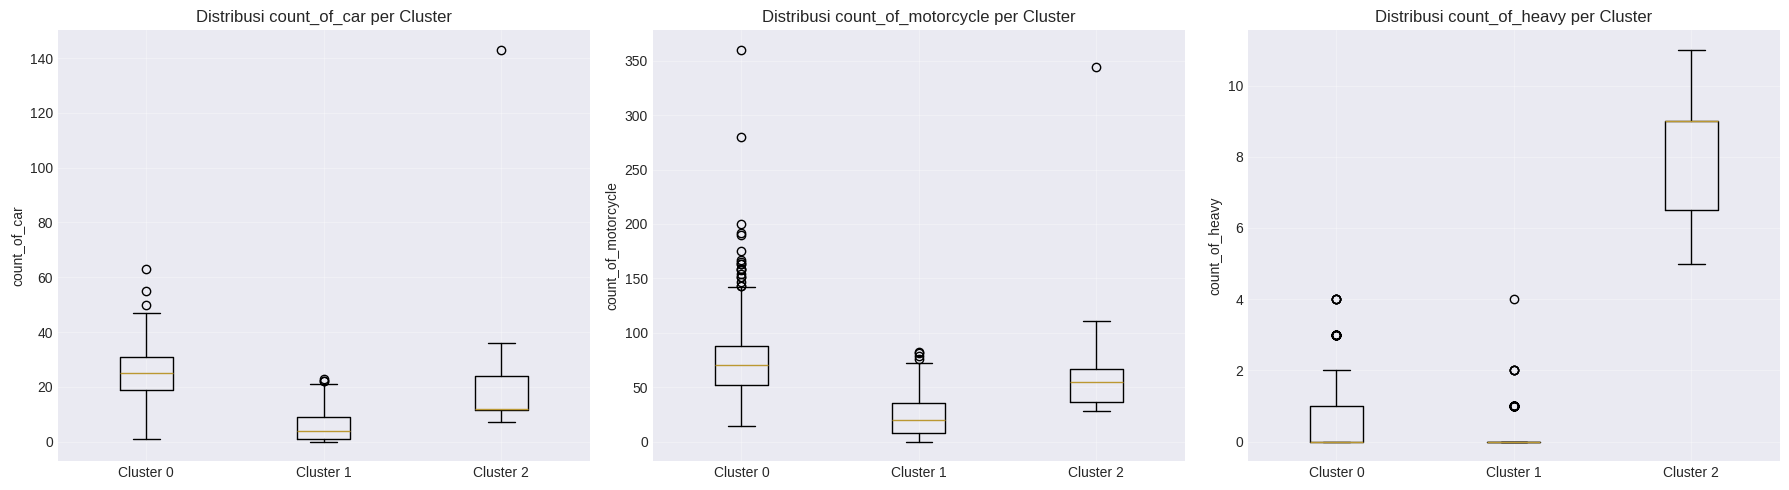

In [65]:
# Boxplot per cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(features):
    data_to_plot = [df_final[df_final['cluster'] == i][feature] for i in range(3)]
    axes[idx].boxplot(data_to_plot, labels=[f'Cluster {i}' for i in range(3)])
    axes[idx].set_title(f'Distribusi {feature} per Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 17. Interpretasi Cluster

# CLUSTERING K-MEDOIDS

---

## 18. Simpan Hasil Clustering

## 19. K-Medoids Clustering dengan K=3

In [66]:
# Statistik per cluster K-Medoids (nilai original tanpa weight)
print("\n" + "="*60)
print("KARAKTERISTIK SETIAP CLUSTER K-MEDOIDS (Original Values)")
print("="*60)

for cluster_id in sorted(df_final['cluster_kmedoids'].unique()):
    cluster_data = df_final[df_final['cluster_kmedoids'] == cluster_id][features]
    print(f"\n--- CLUSTER {cluster_id} ---")
    print(f"Jumlah data: {len(cluster_data)}")
    print(f"\nMean:")
    print(cluster_data.mean())
    print(f"\nMedian:")
    print(cluster_data.median())
    print(f"\nStd Dev:")
    print(cluster_data.std())


KARAKTERISTIK SETIAP CLUSTER K-MEDOIDS (Original Values)


KeyError: 'cluster_kmedoids'

# Membuat model K-Medoids dengan k=3 menggunakan pyclustering
# Inisialisasi dengan medoid indices secara random
np.random.seed(random_state)
initial_medoids = np.random.choice(len(X_scaled), size=3, replace=False).tolist()

# Buat instance K-Medoids (tanpa data_type parameter)
kmedoids_instance = kmedoids(X_scaled, initial_medoids)

# Run clustering
kmedoids_instance.process()

# Dapatkan hasil
clusters_kmedoids = kmedoids_instance.get_clusters()
medoid_indices = kmedoids_instance.get_medoids()

# Konversi clusters ke labels
cluster_labels_kmedoids = np.zeros(len(X_scaled), dtype=int)
for cluster_id, cluster in enumerate(clusters_kmedoids):
    for idx in cluster:
        cluster_labels_kmedoids[idx] = cluster_id

# Menambahkan hasil clustering ke dataframe (kolom baru)
df_final['cluster_kmedoids'] = cluster_labels_kmedoids

print(f"Jumlah cluster: 3")
print(f"\nJumlah data per cluster (K-Medoids):")
print(df_final['cluster_kmedoids'].value_counts().sort_index())

# Medoid clusters (dalam skala scaled)
medoids_scaled = X_scaled[medoid_indices]
medoids_weighted = scaler.inverse_transform(medoids_scaled)

print("\nMedoid clusters (weighted values):")
medoids_df = pd.DataFrame(medoids_weighted, columns=features)
print(medoids_df)

# Indices of medoids
print(f"\nIndices dari medoid (actual data points):")
print(f"Medoid indices: {medoid_indices}")

In [ ]:
# Hitung Silhouette Score untuk K-Medoids
silhouette_avg_kmedoids = silhouette_score(X_scaled, cluster_labels_kmedoids)

print("="*60)
print("EVALUASI K-MEDOIDS: SILHOUETTE SCORE")
print("="*60)
print(f"\nSilhouette Score: {silhouette_avg_kmedoids:.4f}")
print(f"\nInterpretasi:")
if silhouette_avg_kmedoids > 0.7:
    print("  > 0.7: Strong structure (Sangat baik)")
elif silhouette_avg_kmedoids > 0.5:
    print("  0.5-0.7: Reasonable structure (Baik)")
elif silhouette_avg_kmedoids > 0.25:
    print("  0.25-0.5: Weak structure (Cukup)")
else:
    print("  < 0.25: No substantial structure (Kurang baik)")

# Hitung silhouette score per cluster
sample_silhouette_values_kmedoids = silhouette_samples(X_scaled, cluster_labels_kmedoids)

print(f"\nSilhouette Score per Cluster:")
for cluster_id in sorted(df_final['cluster_kmedoids'].unique()):
    cluster_silhouette_values = sample_silhouette_values_kmedoids[cluster_labels_kmedoids == cluster_id]
    print(f"  Cluster {cluster_id}: {cluster_silhouette_values.mean():.4f}")

In [ ]:
# Visualisasi Silhouette Plot K-Medoids
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for i in range(3):
    # Aggregate silhouette scores untuk cluster i
    ith_cluster_silhouette_values = sample_silhouette_values_kmedoids[cluster_labels_kmedoids == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / 3)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot untuk K-Medoids Clustering (K=3)')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')

# Garis vertikal untuk rata-rata silhouette score
ax.axvline(x=silhouette_avg_kmedoids, color="red", linestyle="--", label=f'Average: {silhouette_avg_kmedoids:.4f}')
ax.legend()

plt.tight_layout()
plt.show()

## 21. Evaluasi K-Medoids: BSS/TSS Ratio

In [ ]:
# Hitung BSS untuk K-Medoids (TSS sama karena data yang sama)
bss_kmedoids = 0
for i in range(3):
    cluster_data = X_scaled[cluster_labels_kmedoids == i]
    cluster_size = len(cluster_data)
    cluster_center = medoids_scaled[i]
    bss_kmedoids += cluster_size * np.sum((cluster_center - overall_mean) ** 2)

# Hitung WSS untuk K-Medoids
wss_kmedoids = kmedoids.inertia_

# Hitung BSS/TSS ratio
bss_tss_ratio_kmedoids = bss_kmedoids / tss

print("="*60)
print("EVALUASI K-MEDOIDS: BSS/TSS RATIO")
print("="*60)
print(f"\nTotal Sum of Squares (TSS): {tss:.4f}")
print(f"Between-cluster Sum of Squares (BSS): {bss_kmedoids:.4f}")
print(f"Within-cluster Sum of Squares (WSS): {wss_kmedoids:.4f}")
print(f"\nVerifikasi: BSS + WSS = {bss_kmedoids + wss_kmedoids:.4f} (should equal TSS = {tss:.4f})")
print(f"\n" + "="*60)
print(f"BSS/TSS Ratio: {bss_tss_ratio_kmedoids:.4f} ({bss_tss_ratio_kmedoids*100:.2f}%)")
print("="*60)
print(f"\nInterpretasi:")
print(f"  BSS/TSS = {bss_tss_ratio_kmedoids:.4f} berarti {bss_tss_ratio_kmedoids*100:.2f}% variasi data")
print(f"  dijelaskan oleh pembagian cluster.")
print(f"\n  WSS/TSS = {(wss_kmedoids/tss):.4f} berarti {(wss_kmedoids/tss)*100:.2f}% variasi data")
print(f"  masih ada dalam cluster (tidak dijelaskan).")

if bss_tss_ratio_kmedoids > 0.7:
    print("\n  > 0.7: Clustering sangat baik")
elif bss_tss_ratio_kmedoids > 0.5:
    print("\n  0.5-0.7: Clustering baik")
elif bss_tss_ratio_kmedoids > 0.3:
    print("\n  0.3-0.5: Clustering cukup")
else:
    print("\n  < 0.3: Clustering kurang baik")

## 22. Visualisasi K-Medoids

In [ ]:
# Visualisasi 3D K-Medoids
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
colors = ['red', 'blue', 'green']
for i in range(3):
    cluster_data = df_final[df_final['cluster_kmedoids'] == i]
    ax.scatter(cluster_data['count_of_car'], 
               cluster_data['count_of_motorcycle'], 
               cluster_data['count_of_heavy'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)

# Plot medoids (dalam skala original, harus di-unweight)
medoids_original = medoids_weighted.copy()
for idx, feature in enumerate(features):
    medoids_original[:, idx] = medoids_original[:, idx] / weights[feature]

ax.scatter(medoids_original[:, 0], 
           medoids_original[:, 1], 
           medoids_original[:, 2],
           c='black', marker='X', s=200, label='Medoids', edgecolor='yellow', linewidth=2)

ax.set_xlabel('Count of Car')
ax.set_ylabel('Count of Motorcycle')
ax.set_zlabel('Count of Heavy')
ax.set_title('K-Medoids Clustering (K=3) - 3D Visualization')
ax.legend()

plt.tight_layout()
plt.show()

## 23. Perbandingan K-Means vs K-Medoids

In [ ]:
# Perbandingan metrik
print("="*70)
print("PERBANDINGAN K-MEANS VS K-MEDOIDS")
print("="*70)

comparison_data = {
    'Metrik': [
        'Silhouette Score',
        'BSS',
        'WSS',
        'TSS',
        'BSS/TSS Ratio (%)',
        'WSS/TSS Ratio (%)'
    ],
    'K-Means': [
        f"{silhouette_avg:.4f}",
        f"{bss:.4f}",
        f"{wss:.4f}",
        f"{tss:.4f}",
        f"{bss_tss_ratio*100:.2f}%",
        f"{(wss/tss)*100:.2f}%"
    ],
    'K-Medoids': [
        f"{silhouette_avg_kmedoids:.4f}",
        f"{bss_kmedoids:.4f}",
        f"{wss_kmedoids:.4f}",
        f"{tss:.4f}",
        f"{bss_tss_ratio_kmedoids*100:.2f}%",
        f"{(wss_kmedoids/tss)*100:.2f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n")
print(comparison_df.to_string(index=False))

print("\n" + "="*70)
print("INTERPRETASI PERBANDINGAN:")
print("="*70)

# Perbandingan Silhouette Score
print("\n1. Silhouette Score:")
if silhouette_avg > silhouette_avg_kmedoids:
    print(f"   ✓ K-Means LEBIH BAIK ({silhouette_avg:.4f} > {silhouette_avg_kmedoids:.4f})")
    print(f"     Selisih: {abs(silhouette_avg - silhouette_avg_kmedoids):.4f}")
elif silhouette_avg < silhouette_avg_kmedoids:
    print(f"   ✓ K-Medoids LEBIH BAIK ({silhouette_avg_kmedoids:.4f} > {silhouette_avg:.4f})")
    print(f"     Selisih: {abs(silhouette_avg - silhouette_avg_kmedoids):.4f}")
else:
    print(f"   = SAMA ({silhouette_avg:.4f})")

# Perbandingan BSS/TSS
print("\n2. BSS/TSS Ratio:")
if bss_tss_ratio > bss_tss_ratio_kmedoids:
    print(f"   ✓ K-Means LEBIH BAIK ({bss_tss_ratio*100:.2f}% > {bss_tss_ratio_kmedoids*100:.2f}%)")
    print(f"     Selisih: {abs(bss_tss_ratio - bss_tss_ratio_kmedoids)*100:.2f}%")
elif bss_tss_ratio < bss_tss_ratio_kmedoids:
    print(f"   ✓ K-Medoids LEBIH BAIK ({bss_tss_ratio_kmedoids*100:.2f}% > {bss_tss_ratio*100:.2f}%)")
    print(f"     Selisih: {abs(bss_tss_ratio - bss_tss_ratio_kmedoids)*100:.2f}%")
else:
    print(f"   = SAMA ({bss_tss_ratio*100:.2f}%)")

# Perbandingan WSS
print("\n3. Within-cluster Sum of Squares (WSS):")
print(f"   WSS lebih kecil = clustering lebih baik (data lebih compact)")
if wss < wss_kmedoids:
    print(f"   ✓ K-Means LEBIH BAIK ({wss:.4f} < {wss_kmedoids:.4f})")
    print(f"     Selisih: {abs(wss - wss_kmedoids):.4f}")
elif wss > wss_kmedoids:
    print(f"   ✓ K-Medoids LEBIH BAIK ({wss_kmedoids:.4f} < {wss:.4f})")
    print(f"     Selisih: {abs(wss - wss_kmedoids):.4f}")
else:
    print(f"   = SAMA ({wss:.4f})")

print("\n" + "="*70)
print("KESIMPULAN:")
print("="*70)

# Hitung skor
kmeans_score = 0
kmedoids_score = 0

if silhouette_avg > silhouette_avg_kmedoids:
    kmeans_score += 1
elif silhouette_avg < silhouette_avg_kmedoids:
    kmedoids_score += 1

if bss_tss_ratio > bss_tss_ratio_kmedoids:
    kmeans_score += 1
elif bss_tss_ratio < bss_tss_ratio_kmedoids:
    kmedoids_score += 1

if wss < wss_kmedoids:
    kmeans_score += 1
elif wss > wss_kmedoids:
    kmedoids_score += 1

print(f"\nSkor: K-Means = {kmeans_score}, K-Medoids = {kmedoids_score}")

if kmeans_score > kmedoids_score:
    print("\n✓ K-Means menghasilkan clustering yang LEBIH BAIK untuk dataset ini")
elif kmeans_score < kmedoids_score:
    print("\n✓ K-Medoids menghasilkan clustering yang LEBIH BAIK untuk dataset ini")
else:
    print("\n= K-Means dan K-Medoids menghasilkan clustering yang SETARA untuk dataset ini")

In [ ]:
# Visualisasi perbandingan side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means
ax1 = axes[0]
for i in range(3):
    cluster_data = df_final[df_final['cluster'] == i]
    ax1.scatter(cluster_data['count_of_car'], 
               cluster_data['count_of_motorcycle'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
ax1.scatter(centroids_original[:, 0], 
           centroids_original[:, 1],
           c='black', marker='X', s=200, edgecolor='yellow', linewidth=2, label='Centroids')
ax1.set_xlabel('Count of Car')
ax1.set_ylabel('Count of Motorcycle')
ax1.set_title(f'K-Means (Silhouette: {silhouette_avg:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# K-Medoids
ax2 = axes[1]
for i in range(3):
    cluster_data = df_final[df_final['cluster_kmedoids'] == i]
    ax2.scatter(cluster_data['count_of_car'], 
               cluster_data['count_of_motorcycle'],
               c=colors[i], label=f'Cluster {i}', alpha=0.6, s=30)
ax2.scatter(medoids_original[:, 0], 
           medoids_original[:, 1],
           c='black', marker='X', s=200, edgecolor='yellow', linewidth=2, label='Medoids')
ax2.set_xlabel('Count of Car')
ax2.set_ylabel('Count of Motorcycle')
ax2.set_title(f'K-Medoids (Silhouette: {silhouette_avg_kmedoids:.4f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 24. Simpan Hasil Final

In [ ]:
# Simpan data dengan kedua label cluster
df_final.to_csv('assets/file/vehicle_counts_clustered.csv', index=False)
print("Data dengan label cluster (K-Means & K-Medoids) telah disimpan ke:")
print("  assets/file/vehicle_counts_clustered.csv")

print("\n" + "="*70)
print("RINGKASAN AKHIR: PREPROCESSING DAN CLUSTERING")
print("="*70)

print("\n--- PREPROCESSING ---")
print(f"Total data awal: 1703 baris")
print(f"Total data setelah preprocessing: {len(df_final)} baris")
print(f"Rentang waktu: {df_final['datetime_start'].min()} - {df_final['datetime_end'].max()}")

print("\n--- WEIGHTS ---")
for k, v in weights.items():
    print(f"  {k}: {v}")

print("\n--- K-MEANS (K=3) ---")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  BSS/TSS Ratio: {bss_tss_ratio:.4f} ({bss_tss_ratio*100:.2f}%)")
print(f"  WSS: {wss:.4f}")

print("\n--- K-MEDOIDS (K=3) ---")
print(f"  Silhouette Score: {silhouette_avg_kmedoids:.4f}")
print(f"  BSS/TSS Ratio: {bss_tss_ratio_kmedoids:.4f} ({bss_tss_ratio_kmedoids*100:.2f}%)")
print(f"  WSS: {wss_kmedoids:.4f}")

print("\n" + "="*70)
print("✓ PREPROCESSING DAN CLUSTERING SELESAI!")
print("="*70)

In [ ]:
# Simpan data dengan label cluster
df_final.to_csv('assets/file/vehicle_counts_clustered.csv', index=False)
print("Data dengan label cluster telah disimpan ke: assets/file/vehicle_counts_clustered.csv")

# Simpan ringkasan evaluasi
print("\n" + "="*60)
print("RINGKASAN EVALUASI CLUSTERING")
print("="*60)
print(f"K (jumlah cluster): 3")
print(f"\nWeights:")
for k, v in weights.items():
    print(f"  {k}: {v}")
print(f"\nMetrik Evaluasi:")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  BSS/TSS Ratio: {bss_tss_ratio:.4f} ({bss_tss_ratio*100:.2f}%)")
print(f"  BSS: {bss:.4f}")
print(f"  TSS: {tss:.4f}")
print(f"  WSS: {wss:.4f}")

print("\n" + "="*60)
print("PREPROCESSING DAN CLUSTERING SELESAI!")
print("="*60)

Data dengan label cluster telah disimpan ke: assets/file/vehicle_counts_clustered.csv

RINGKASAN EVALUASI CLUSTERING
K (jumlah cluster): 3

Weights:
  count_of_car: 1.0
  count_of_motorcycle: 0.5
  count_of_heavy: 2.0

Metrik Evaluasi:
  Silhouette Score: 0.4539
  BSS/TSS Ratio: 0.5645 (56.45%)
  BSS: 2626.6707
  TSS: 4653.0000
  WSS: 2026.3293

PREPROCESSING DAN CLUSTERING SELESAI!
